# Training a MNIST Digits Classifier with Active Learning

This notebook provides you with a complete code example that uses active learning to train a neural network capable of classifying the MNIST digits.

## Training a Baseline Model

Load the MNIST digits ...

In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_data = datasets.MNIST(root="data", train=True, download=True, 
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, 
                           transform=transforms.ToTensor())

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=False)

... define the classifier neural network ...

In [2]:
import deeplay as dl
import torch.nn as nn

backbone = dl.ConvolutionalNeuralNetwork(1, [64] * 4, 128)
backbone.blocks[1:].pool.configure(nn.MaxPool2d, kernel_size=2)
backbone.blocks[-1].append(dl.Layer(nn.AdaptiveAvgPool2d, output_size=1))
backbone.blocks[-1].append(dl.Layer(nn.Flatten, output_size=1))

head = dl.MultiLayerPerceptron(128, [], 10)

classifier_template = dl.Sequential(backbone, head)

... define, train, and test the classifier with all data ...

In [3]:
import torchmetrics as tm

tm_accuracy = tm.Accuracy(task="multiclass", num_classes=10)

classifier = dl.CategoricalClassifier(
    classifier_template.new(), optimizer=dl.Adam(lr=1e-3), num_classes=10, 
    metrics=[tm_accuracy]
).build()

trainer = dl.Trainer(max_epochs=10, accelerator="cpu")
trainer.fit(classifier, train_dataloader)

full_results = trainer.test(classifier, test_dataloader)


/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_st

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ CrossEntropyLoss │      0 │ train │
│ 1 │ train_metrics │ MetricCollection │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection │      0 │ train │
│ 4 │ model         │ Sequential       │  186 K │ train │
│ 5 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 186 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 186 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 37                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.9901000261306763      │
│       test_loss_epoch        │     0.03406793996691704      │
└──────────────────────────────┴──────────────────────────────┘

## Implementing Multiple Active Learning Strategies

### Implementing a Common Configuration for All Samplings

Configure the general parameters ...

In [4]:
trials, budget_per_iteration, max_budget = 5, 120, 1800
rounds = max_budget // budget_per_iteration - 1  # Number of rounds per trial.

... and implement a function to perform an active training loop.

In [5]:
def al_loop(strategy, epochs):
    """Perform active learning loop."""
    trainer = dl.Trainer(max_epochs=epochs, enable_checkpointing=False,
                         enable_model_summary=False, accelerator="cpu")   ### enable_model_summary=False)
    trainer.fit(strategy)

    test_results = trainer.test(strategy, test_dataloader)
    accuracy = test_results[0]["testMulticlassAccuracy"]

    strategy.query_and_update(budget_per_iteration)
    strategy.reset_model()  # Reset the model to the initial state.
    return accuracy

### Uniform Random Sampling

In [6]:
import deeplay.activelearning as al
import numpy as np

uniform_acc = np.empty((trials, rounds))
for t in range(trials):
    uniform_train_pool = al.ActiveLearningDataset(train_data)
    uniform_train_pool.annotate_random(budget_per_iteration)
    uniform_strategy = al.UniformStrategy(
        classifier_template.new(), train_pool=uniform_train_pool, 
        test=test_data, batch_size=128, test_metrics=[tm_accuracy],
    ).build()

    for r in range(rounds):
        print(f"Trial {t + 1}/{trials} Round {r + 1}/{rounds}", flush=True)
        uniform_acc[t, r] = al_loop(uniform_strategy, epochs=10)

Trial 1/5 Round 1/14


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.09740000218153      │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 2/14


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.2720000147819519     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 3/14


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.6775000095367432     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 4/14


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7354000210762024     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 5/14


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7419000267982483     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 6/14


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8321999907493591     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 7/14


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8532999753952026     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 8/14


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8988999724388123     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 9/14


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.88919997215271      │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 10/14


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9070000052452087     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 11/14


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.92330002784729      │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 12/14


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9138000011444092     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 13/14


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9247000217437744     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 14/14


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9143999814987183     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 1/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.15060000121593475    │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 2/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.2937999963760376     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 3/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.6035000085830688     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 4/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7333999872207642     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 5/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7465000152587891     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 6/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7605000138282776     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 7/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8454999923706055     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 8/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8730999827384949     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 9/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8687000274658203     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 10/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8844000101089478     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 11/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9082000255584717     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 12/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9093999862670898     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 13/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9164999723434448     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 14/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9071000218391418     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 1/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.15850000083446503    │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 2/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.5159000158309937     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 3/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.6075000166893005     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 4/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.5916000008583069     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 5/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7544999718666077     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 6/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7957000136375427     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 7/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8518999814987183     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 8/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │           0.875           │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 9/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8574000000953674     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 10/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8913000226020813     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 11/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8928999900817871     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 12/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8511000275611877     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 13/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9168999791145325     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 14/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9301999807357788     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 1/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.11089999973773956    │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 2/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.4203000068664551     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 3/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.6187999844551086     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 4/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.6826000213623047     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 5/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7301999926567078     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 6/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.796999990940094     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 7/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.800599992275238     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 8/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8769999742507935     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 9/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8532000184059143     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 10/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8866999745368958     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 11/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8981999754905701     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 12/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9003000259399414     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 13/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8931000232696533     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 14/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9269999861717224     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 1/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.10639999806880951    │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 2/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.4575999975204468     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 3/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.684499979019165     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 4/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7440999746322632     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 5/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7835999727249146     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 6/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8115000128746033     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 7/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8414000272750854     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 8/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8774999976158142     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 9/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.870199978351593     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 10/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8844000101089478     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 11/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9121999740600586     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 12/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9036999940872192     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 13/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9248999953269958     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 14/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9146000146865845     │
└───────────────────────────┴───────────────────────────┘

### Uncertainty Sampling

In [7]:
uncertainty_acc = np.empty((trials, rounds))
for t in range(trials):
    uncertainty_pool = al.ActiveLearningDataset(train_data)
    uncertainty_pool.annotate_random(budget_per_iteration)
    uncertainty_strategy = al.UncertaintyStrategy(
        classifier_template.new(), train_pool=uncertainty_pool,
        criterion=al.Margin(), batch_size=128, test_metrics=[tm_accuracy],
    ).build()

    for r in range(rounds):
        print(f"Trial {t + 1}/{trials} Round {r + 1}/{rounds}", flush=True)
        uncertainty_acc[t, r] = al_loop(uncertainty_strategy, epochs=10)

Trial 1/5 Round 1/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.10320000350475311    │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 2/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.11349999904632568    │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 3/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.22830000519752502    │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 4/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.38100001215934753    │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 5/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.6028000116348267     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 6/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7228999733924866     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 7/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8011000156402588     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 8/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8604000210762024     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 9/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8805999755859375     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 10/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9003999829292297     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 11/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9319999814033508     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 12/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9408000111579895     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 13/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9415000081062317     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 14/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9498000144958496     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 1/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.19820000231266022    │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 2/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.10090000182390213    │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 3/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.11349999904632568    │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 4/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.2328999936580658     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 5/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.49959999322891235    │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 6/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.698199987411499     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 7/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8269000053405762     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 8/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8593999743461609     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 9/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9054999947547913     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 10/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.90829998254776      │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 11/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9316999912261963     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 12/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9358000159263611     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 13/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9387999773025513     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 14/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9041000008583069     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 1/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.17970000207424164    │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 2/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.24619999527931213    │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 3/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.337799996137619     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 4/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.6902999877929688     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 5/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7766000032424927     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 6/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.840499997138977     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 7/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9028000235557556     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 8/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8964999914169312     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 9/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9164999723434448     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 10/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9379000067710876     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 11/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9265999794006348     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 12/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.887499988079071     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 13/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9365000128746033     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 14/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9381999969482422     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 1/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.10320000350475311    │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 2/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.09799999743700027    │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 3/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.2053000032901764     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 4/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.2797999978065491     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 5/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.46549999713897705    │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 6/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.641700029373169     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 7/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7641000151634216     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 8/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8299999833106995     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 9/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8802000284194946     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 10/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8715000152587891     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 11/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9146000146865845     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 12/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8899999856948853     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 13/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.894599974155426     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 14/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9108999967575073     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 1/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.17239999771118164    │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 2/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.14800000190734863    │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 3/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.1981000006198883     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 4/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.6175000071525574     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 5/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.691100001335144     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 6/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.758899986743927     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 7/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8547999858856201     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 8/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.890500009059906     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 9/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8939999938011169     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 10/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9151999950408936     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 11/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8906999826431274     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 12/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9236999750137329     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 13/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9380999803543091     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 14/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9372000098228455     │
└───────────────────────────┴───────────────────────────┘

### Adversarial Sampling

In [8]:
import torch

adversarial_acc = np.empty((trials, rounds))
for t in range(trials):
    discriminator = dl.MultiLayerPerceptron(128, [128, 128], 1,
                                            out_activation=torch.nn.Sigmoid())
    discriminator.initialize(dl.initializers.Kaiming())

    adversarial_train_pool = al.ActiveLearningDataset(train_data)
    adversarial_train_pool.annotate_random(budget_per_iteration)
    adversarial_strategy = al.AdversarialStrategy(
        backbone=backbone.new(), classification_head=head.new(),
        discriminator_head=discriminator.new(),
        train_pool=adversarial_train_pool, criterion=al.Margin(), 
        batch_size=128, test_metrics=[tm_accuracy],
    ).build()

    for r in range(rounds):
        print(f"Trial {t + 1}/{trials} Round {r + 1}/{rounds}", flush=True)
        adversarial_acc[t, r] = al_loop(adversarial_strategy, epochs=5)

Trial 1/5 Round 1/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7703999876976013     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 2/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8804000020027161     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 3/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9259999990463257     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 4/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8845000267028809     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 5/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9448000192642212     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 6/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9567000269889832     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 7/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9679999947547913     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 8/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9747999906539917     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 9/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.973800003528595     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 10/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9782999753952026     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 11/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9805999994277954     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 12/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9821000099182129     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 13/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9836000204086304     │
└───────────────────────────┴───────────────────────────┘

Trial 1/5 Round 14/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9825000166893005     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 1/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7874000072479248     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 2/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9193999767303467     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 3/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9429000020027161     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 4/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9617999792098999     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 5/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.965499997138977     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 6/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9679999947547913     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 7/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9725000262260437     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 8/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9729999899864197     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 9/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9760000109672546     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 10/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9768999814987183     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 11/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.980400025844574     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 12/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9789999723434448     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 13/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9819999933242798     │
└───────────────────────────┴───────────────────────────┘

Trial 2/5 Round 14/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9825999736785889     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 1/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8310999870300293     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 2/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8671000003814697     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 3/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9290000200271606     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 4/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9473999738693237     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 5/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9613000154495239     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 6/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9624000191688538     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 7/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9685999751091003     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 8/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9682999849319458     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 9/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9736999869346619     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 10/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9764000177383423     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 11/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9818999767303467     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 12/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9797999858856201     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 13/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9812999963760376     │
└───────────────────────────┴───────────────────────────┘

Trial 3/5 Round 14/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9796000123023987     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 1/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.7854999899864197     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 2/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.916100025177002     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 3/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9413999915122986     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 4/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.949999988079071     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 5/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.958899974822998     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 6/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9718000292778015     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 7/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.972000002861023     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 8/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9776999950408936     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 9/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9797999858856201     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 10/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9815000295639038     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 11/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9818999767303467     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 12/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9775999784469604     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 13/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9814000129699707     │
└───────────────────────────┴───────────────────────────┘

Trial 4/5 Round 14/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.984499990940094     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 1/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.8187999725341797     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 2/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │     0.907800018787384     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 3/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9438999891281128     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 4/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9190000295639038     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 5/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9466000199317932     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 6/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9607999920845032     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 7/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9624999761581421     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 8/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9700000286102295     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 9/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9692000150680542     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 10/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9753000140190125     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 11/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9758999943733215     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 12/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9772999882698059     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 13/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9785000085830688     │
└───────────────────────────┴───────────────────────────┘

Trial 5/5 Round 14/14


Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  testMulticlassAccuracy   │    0.9793000221252441     │
└───────────────────────────┴───────────────────────────┘

## Comparing the Performance of the Active Learning Strategies

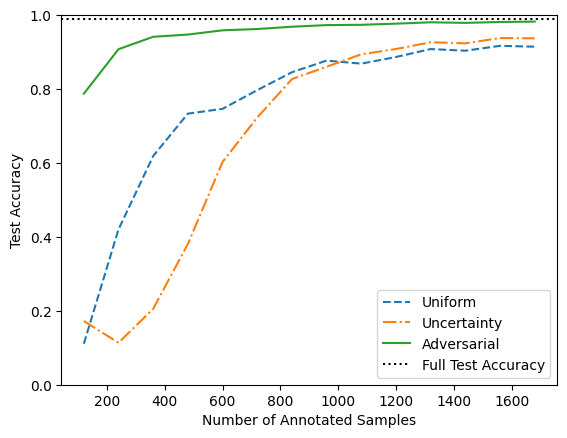

In [20]:
import matplotlib.pyplot as plt

x = np.arange(budget_per_iteration, max_budget, budget_per_iteration)

plt.plot(x, np.median(uniform_acc, 0), label="Uniform", linestyle="--")
plt.plot(x, np.median(uncertainty_acc, 0), label="Uncertainty", linestyle="-.")
plt.plot(x, np.median(adversarial_acc, 0), label="Adversarial", linestyle="-")
plt.axhline(full_results[0]["testMulticlassAccuracy_epoch"], 
            label="Full Test Accuracy", color="black", linestyle=":")
plt.xlabel("Number of Annotated Samples")
plt.ylabel("Test Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.plot()